# Group 10 - First Year Project 
### Data Science at ITU 
## Project 1 - Road collisions analysis 2021 

The first project of Data Science's second semester required us to inform various city leaders around the United Kingdom about traffic fatalities and injuries; and give some insight for urban transport planning. This jupyter notebook presents Group 10's exploration of 2019 UK road collision data with complimentary analysis, visualisation and findings with relation to the city of Sheffield.


This notebook contains all the code developed in the Project 1 - Road collision analysis 2021

Contact/Group: 
- Florian Micliuc(flmi@itu.dk)
- Louis Caspar Brandt (locb@itu.dk)
- Iben Mai Huse (ibhu@itu.dk)
- Katalin Literati-Dobos (klit@itu.dk)
- Ruben Jonsman (rubj@itu.dk)

## Imports

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2_contingency
import seaborn as sns
import folium
from folium import plugins 
from folium.plugins import HeatMap, MarkerCluster
import shapely
import json 
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import branca
import branca.colormap as cm

# Task 0 - Data filtering and cleaning

## Loading data
Our first task invovles loading our 3 csv files (downloaded from https://data.gov.uk/dataset/road-accidents-safety-data on the 4th January 2021) into a traversable data structure we can start working with; such as a dictionary. We will then need to start the process of filtering and cleaning our data.

In [2]:
raw_data = {}

TITLES = ['accidents', 'casualties', 'vehicles'] # Capitalisation is the standard for constants

Pandas has a convinient method for reading in csv files and storing the data in a DataFrame structure offers flexibility.

In [3]:
raw_data['accidents'] = pd.read_csv("../data/raw/Road Safety Data - Accidents 2019.csv", dtype = None, encoding='utf-8-sig')
raw_data['casualties'] = pd.read_csv("../data/raw/Road Safety Data - Casualties 2019.csv", dtype = None, encoding='utf-8-sig')
raw_data['vehicles'] = pd.read_csv("../data/raw/Road Safety Data- Vehicles 2019.csv", dtype = None, encoding='utf-8-sig') # File name missing a space before hyphen 

C:\Users\ruben\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\ruben\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
for TITLE in TITLES:
    print(TITLE + "\tDataFrame shape: " + str(raw_data[TITLE].shape))

accidents	DataFrame shape: (117536, 32)
casualties	DataFrame shape: (153158, 16)
vehicles	DataFrame shape: (216381, 23)


 ### Data type insight

Most of the variables analyzed were labeled as categorical variables and a few were quantitative (e.g. ratio : Age). Analyzing these variables gave an overall idea over the layout and the precision of the data set. Therefore, this analysis provided very important data points which helped shape the layout of the research (e.g. nominal variable : Accident Severity, ratio : Age of Driver/Casualty).


## Locating our city
With our data loaded into a dictionary containing DataFrames, we needed to locate the accidents that occured in Sheffield. To do this we made a mask identifying which accidents occured in the local district authority 215, which is the district of Sheffield.


In [5]:
sheffield_mask = (raw_data['accidents']["Local_Authority_(District)"] == 215)

In [6]:
sheffield_data = {}

sheffield_data['accidents'] = raw_data['accidents'][sheffield_mask]

# Viewing the first 5 rows in the dataframe
sheffield_data['accidents'][:5]

Accident_Index  Location_Easting_OSGR  Location_Northing_OSGR  \
44673  2019140805407               429140.0                381931.0   
44674  2019140805409               434290.0                385121.0   
44676  2019140805414               435393.0                391745.0   
44677  2019140805567               433949.0                396778.0   
44680  2019140805955               433662.0                389819.0   

       Longitude   Latitude  Police_Force  Accident_Severity  \
44673  -1.563884  53.333509            14                  2   
44674  -1.486208  53.361875            14                  3   
44676  -1.468895  53.421340            14                  1   
44677  -1.490081  53.466672            14                  2   
44680  -1.495146  53.404142            14                  3   

       Number_of_Vehicles  Number_of_Casualties        Date  ...  \
44673                   2                     1  01/01/2019  ...   
44674                   2                     1  01/01/2019  ...   
44676                   1                     1  01/01/2019  ...   
44677                   2                     1  01/01/2019  ...   
44680                   2                     1  03/01/2019  ...   

       Pedestrian_Crossing-Human_Control  \
44673                                  0   
44674                                  0   
44676                                  0   
44677                                  0   
44680                                  0   

      Pedestrian_Crossing-Physical_Facilities  Light_Conditions  \
44673                                       0                 1   
44674                                       0                 4   
44676                                       1                 4   
44677                                       0                 1   
44680                                       0                 1   

      Weather_Conditions  Road_Surface_Conditions  Special_Conditions_at_Site  \
44673                  1                        2                           0   
44674                  1                        1                           0   
44676                  1                        1                           0   
44677                  1                        1                           0   
44680                  1                        1                           0   

       Carriageway_Hazards  Urban_or_Rural_Area  \
44673                    0                    2   
44674                    0                    1   
44676                    0                    1   
44677                    0                    1   
44680                    0                    1   

       Did_Police_Officer_Attend_Scene_of_Accident  LSOA_of_Accident_Location  
44673                                            1                  E01007926  
44674                                            1                  E01008052  
44676                                            1                  E01008123  
44677                                            1                  E01007901  
44680                                            2                  E01008093  

[5 rows x 32 columns]

In [7]:
sheffield_data['accidents'].shape

(909, 32)

We can now see that there are 909 records of road traffic accidents occuring in Sheffield over 2019. The next step was using the primary key (accident_index) of the accidents to find the accidents in Sheffield that each casualty and vehicle linked to, in order to complete our sheffield_data dictionary.

In [8]:
sheffield_data['accidents']["Accident_Index"][:5]

44673    2019140805407
44674    2019140805409
44676    2019140805414
44677    2019140805567
44680    2019140805955
Name: Accident_Index, dtype: object

In [9]:
for TITLE in TITLES[1:]: 
    sheffield_data[TITLE] = raw_data[TITLE][raw_data[TITLE]['Accident_Index'
                                                           ].isin(sheffield_data["accidents"]["Accident_Index"])]

We can now find out the number of rows and columns in our Sheffield data set

In [10]:
for TITLE in TITLES:
    print("Sheffield " + TITLE + "\tDataFrame shape: " + str(sheffield_data[TITLE].shape))

Sheffield accidents	DataFrame shape: (909, 32)
Sheffield casualties	DataFrame shape: (1191, 16)
Sheffield vehicles	DataFrame shape: (1648, 23)


There is 909 accidents each with 32 attributes.
There is 1191 casualties that occured in the 909 accidents each with 16 attributes.
There is 1648 vehicles that occured in the 909 accidents each with 23 attributes.

This indicates that some accidents involved more than one car, which logically makes sense. If there were a 1:1 ratio between accidents and vehicles, all the vehicles had driven into a object and not caused another vehicle to be part of the accident.

Creating the data files containing only the data from Sheffield

In [11]:
sheffield_data["accidents"].to_csv("../data/processed/sheffield_accidents.csv")
sheffield_data["vehicles"].to_csv("../data/processed/sheffield_vehicles.csv")
sheffield_data["casualties"].to_csv("../data/processed/sheffield_casualties.csv")

## Relational data table model 
In terms of the structure of the three databases or data tables, the accidents table's primary key is used as a foreign key by both the casualties and vehicles data tables, creating a one-to-many link between the accidents and both the casualties and vehicles tables. From this data table structure, we can infer that multiple casualties and vehicles can be involved in a single accident; which makes sense logically.

## Sanity check
Performing a sanity check on our Sheffield road accident data is a critical first step before we can begin to think about further analysing or drawing conclusions from the data. We may also have to sanity check all the data if we wish to draw conclusions therefrom.

### Checking for null values in our road accident dataset

In [12]:
flag = False
for TITLE in TITLES:
    if raw_data[TITLE].isnull().values.any():
        for column in list(raw_data[TITLE].columns):
            nulls = sum(raw_data[TITLE][column].isnull())
            if sum(raw_data[TITLE][column].isnull()):
                print(TITLE + " - " + column + "\t has " + str(nulls) + " null values")
                flag = True
if not flag: print("There are no null values in the dataset")

accidents - Location_Easting_OSGR	 has 28 null values
accidents - Location_Northing_OSGR	 has 28 null values
accidents - Longitude	 has 28 null values
accidents - Latitude	 has 28 null values
accidents - Time	 has 63 null values
accidents - LSOA_of_Accident_Location	 has 5714 null values


### Checking for null values in our sheffield dataset

In [13]:
flag = False
for TITLE in TITLES:
    if sheffield_data[TITLE].isnull().values.any():
        for column in list(sheffield_data[TITLE].columns):
            nulls = sum(sheffield_data[TITLE][column].isnull())
            if sum(sheffield_data[TITLE][column].isnull()):
                print(TITLE + " - " + column + "\t has " + str(nulls) + " null values")
                flag = True
if not flag: print("There are no null values in the dataset")

There are no null values in the dataset


### Visualizing field with unknown values in all three data sets (such as -1)

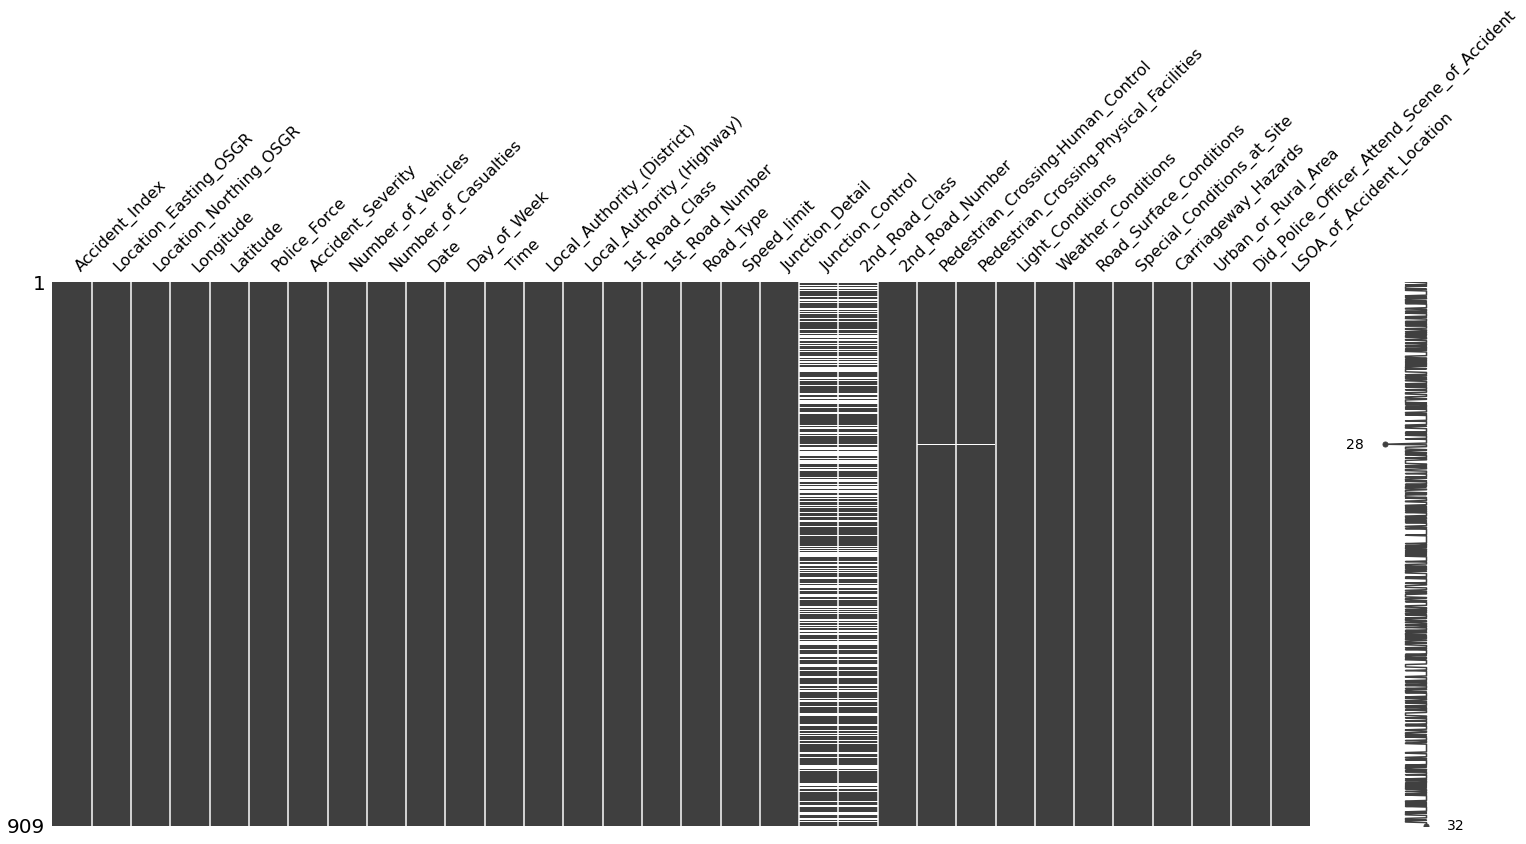

In [14]:
SA = sheffield_data['accidents'].copy()
SA.replace(-1, np.nan, inplace=True)
missingdata_df = SA.columns[SA.isnull().any()].tolist()
msno.matrix(SA);

Below we are plotting count of values per columns ignoring missing values for sheffield_data['accidents'] dataset. We also have sorted columns based on missing values.

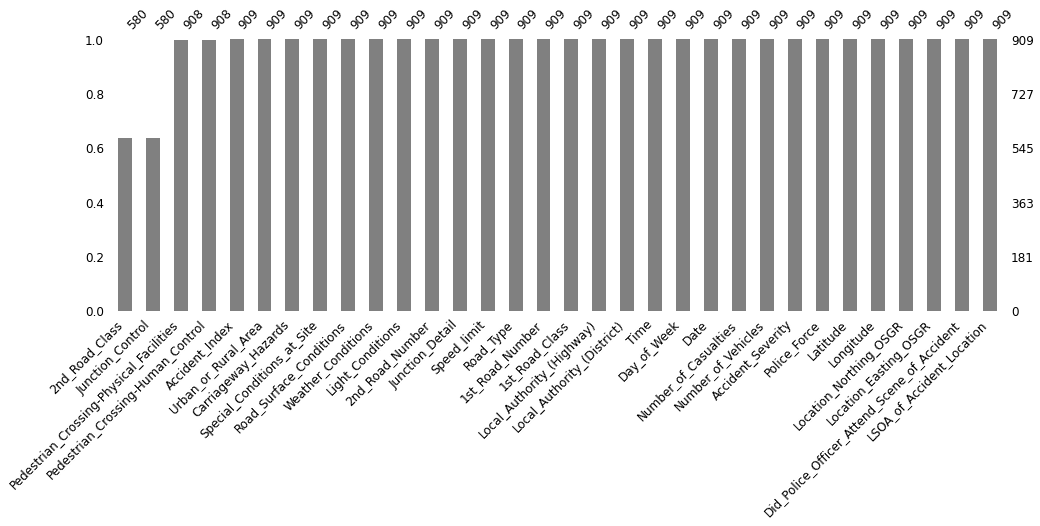

In [15]:
msno.bar(SA, color="gray", sort="ascending", figsize=(16,5), fontsize=12);

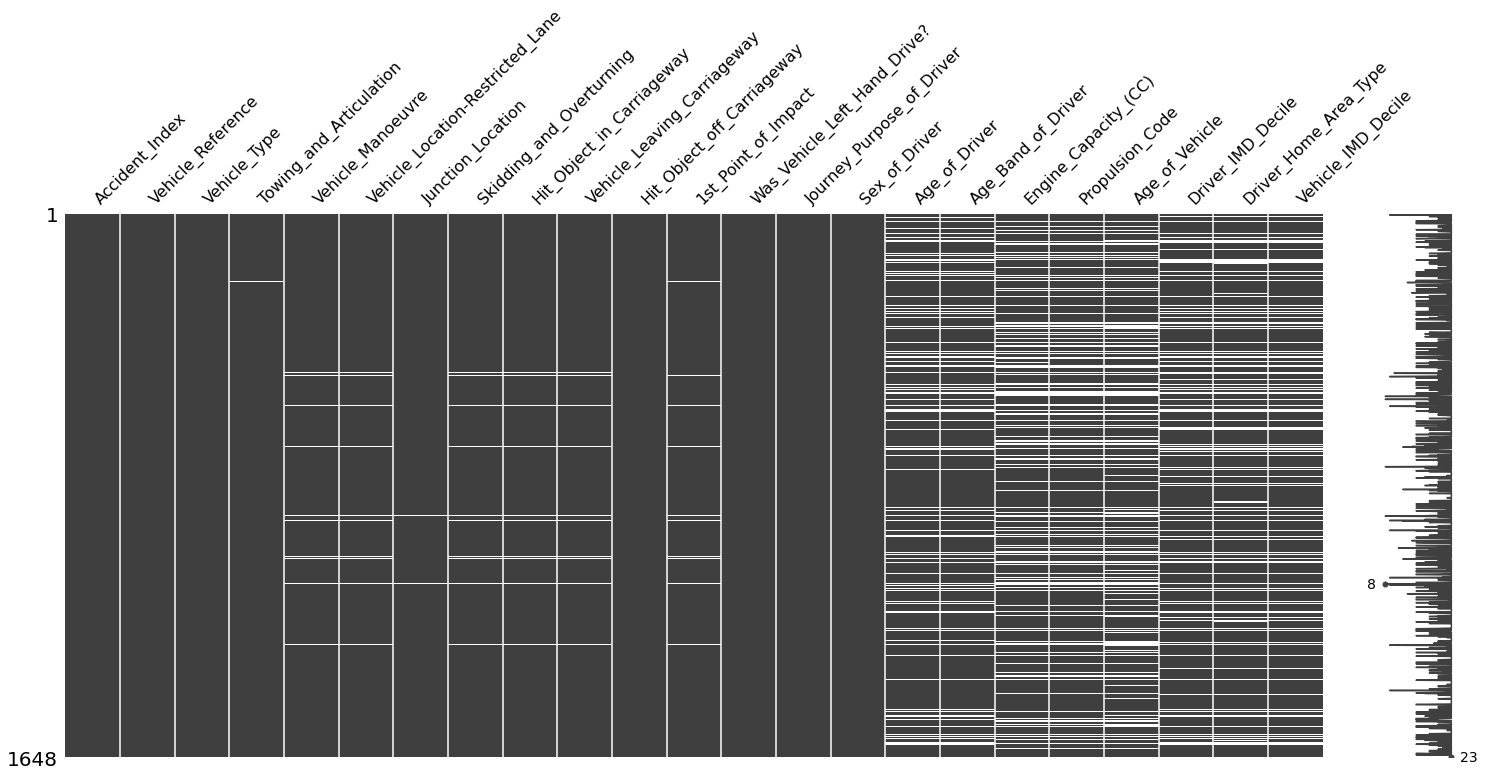

In [16]:
SV = sheffield_data['vehicles'].copy()
SV.replace(-1, np.nan, inplace=True)
missingdata_df = SV.columns[SV.isnull().any()].tolist()
msno.matrix(SV);

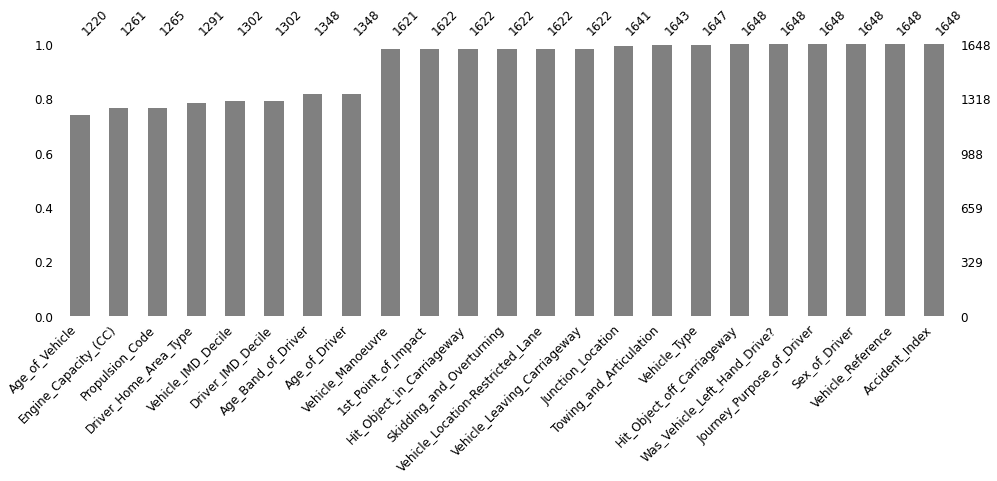

In [17]:
msno.bar(SV, color="gray", sort="ascending", figsize=(16,5), fontsize=12);

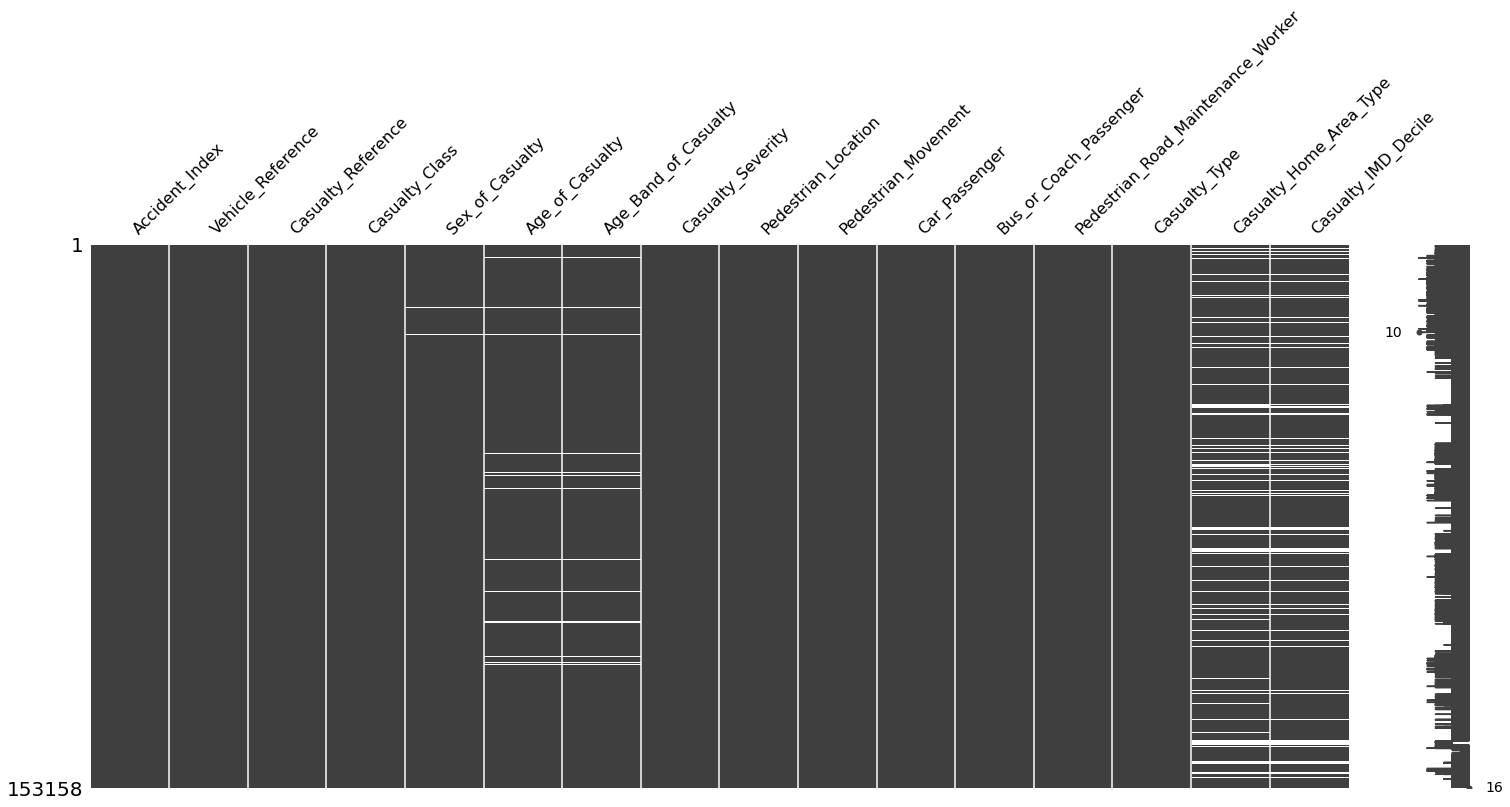

In [18]:
SC = raw_data['casualties'].copy()
SC.replace(-1, np.nan, inplace=True)
missingdata_df = SC.columns[SC.isnull().any()].tolist()
msno.matrix(SC);

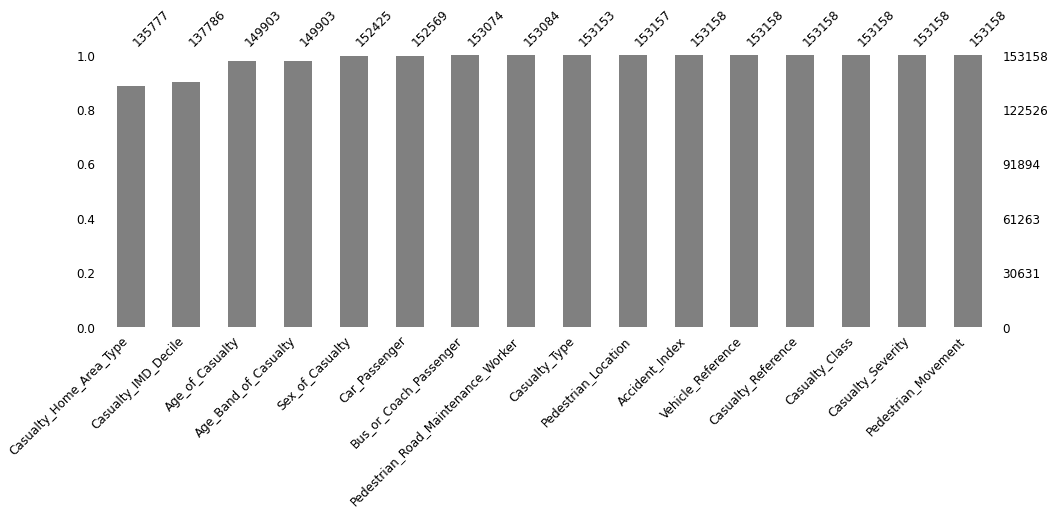

In [19]:
msno.bar(SC, color="gray", sort="ascending", figsize=(16,5), fontsize=12);

### Checking for repeated indexes in our sheffield dataset

In [20]:
if len(sheffield_data["accidents"]["Accident_Index"]) == len((sheffield_data["accidents"]["Accident_Index"].unique())):
    print("No repeated indexes, and thus no need to further investigate")
else: print("Repeated indexes detected")

No repeated indexes, and thus no need to further investigate


## Numerical summary

### Box Plots and Five Number Summaries

In [21]:
mask_num_vehicle = (sheffield_data['accidents']['Number_of_Vehicles']>0)
NumVehicles = sheffield_data['accidents']["Number_of_Vehicles"][mask_num_vehicle]
NumVehicles = NumVehicles.to_frame()
NumVehicles.describe()

Number_of_Vehicles
count          909.000000
mean             1.812981
std              0.673775
min              1.000000
25%              1.000000
50%              2.000000
75%              2.000000
max              6.000000

In [22]:
#sns.boxplot(NumVehicles, width=0.5, color='lightgray').set_title('Number of vehicles in an accident');

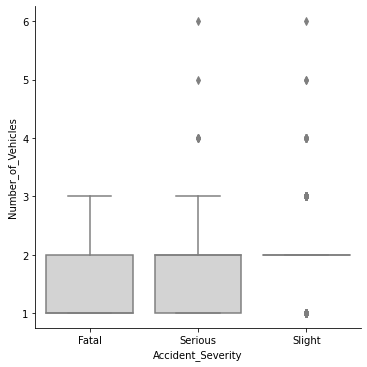

In [23]:
sns.catplot(x='Accident_Severity', y='Number_of_Vehicles', kind="box", data=sheffield_data['accidents'],  height= 5, color='lightgray')
plt.xticks(plt.xticks()[0], ['Fatal', 'Serious', 'Slight']);

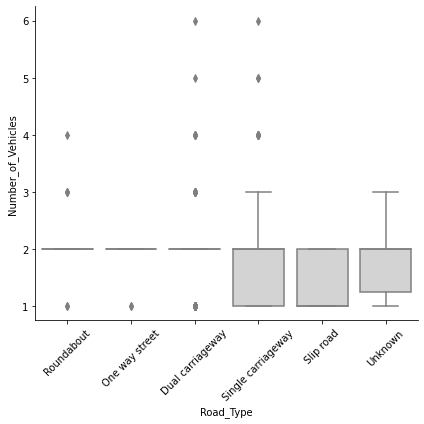

In [24]:
sns.catplot(x='Road_Type', y='Number_of_Vehicles', kind="box", data=sheffield_data['accidents'], height= 6, color='lightgray');
plt.xticks(plt.xticks()[0], ["Roundabout", "One way street", "Dual carriageway", "Single carriageway", "Slip road", "Unknown"])
plt.xticks(rotation=45)
plt.tight_layout();


In [25]:
mask_num_cas = (sheffield_data['accidents']['Number_of_Casualties']>0)
NumCasualties = sheffield_data['accidents']["Number_of_Casualties"][mask_num_cas]
NumCasualties = NumCasualties.to_frame()
NumCasualties.describe()

Number_of_Casualties
count            909.000000
mean               1.310231
std                0.824003
min                1.000000
25%                1.000000
50%                1.000000
75%                1.000000
max               13.000000

In [27]:
#sns.boxplot(NumCasualties, width=0.5, color='lightgray').set_title('Number of Casualties in an accident');

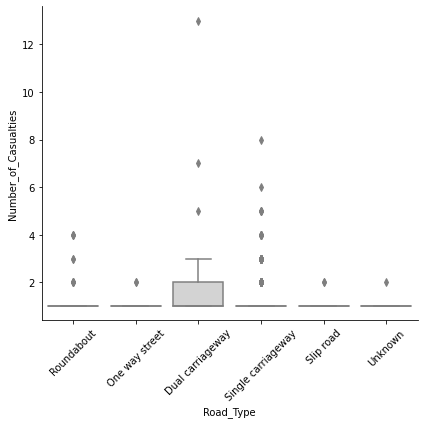

In [28]:
sns.catplot(x='Road_Type', y='Number_of_Casualties', kind="box", data=sheffield_data['accidents'], height= 6, color='lightgray');
plt.xticks(plt.xticks()[0], ["Roundabout", "One way street", "Dual carriageway", "Single carriageway", "Slip road", "Unknown"])
plt.xticks(rotation=45)
plt.tight_layout();

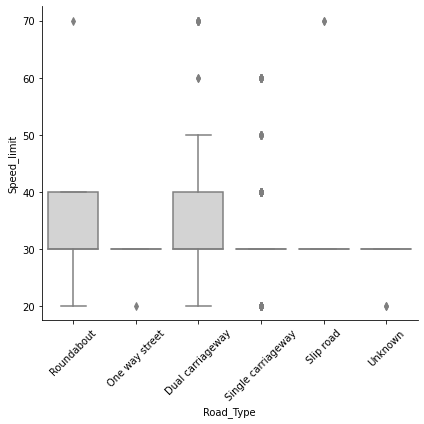

In [29]:
sns.catplot(x='Road_Type', y='Speed_limit', kind="box", data=sheffield_data['accidents'], height= 6, color='lightgray');
plt.xticks(plt.xticks()[0], ["Roundabout", "One way street", "Dual carriageway", "Single carriageway", "Slip road", "Unknown"])
plt.xticks(rotation=45)
plt.tight_layout();

In [30]:
mask_age_vehicle = (sheffield_data['vehicles']['Age_of_Vehicle']>=0)
AgeVehicles = sheffield_data['vehicles']['Age_of_Vehicle'][mask_age_vehicle]
AgeVehicles = AgeVehicles.to_frame()
AgeVehicles.describe()

Age_of_Vehicle
count     1220.000000
mean         8.881967
std          5.177490
min          1.000000
25%          5.000000
50%          9.000000
75%         13.000000
max         55.000000

In [33]:
#p2 =sns.boxplot(AgeVehicles, width=0.5, color='lightgray').set_title('Age of vehicle in an accident');

In [34]:
mask_age = (sheffield_data['vehicles']['Age_of_Driver']>=18)
Age_Driver =  sheffield_data['vehicles']["Age_of_Driver"][mask_age]
Age_Driver = Age_Driver.to_frame()
Age_Driver.describe()

Age_of_Driver
count    1321.000000
mean       40.997729
std        15.937924
min        18.000000
25%        27.000000
50%        39.000000
75%        52.000000
max        91.000000

In [36]:
#sns.boxplot(Age_Driver, width=0.5, color='lightgray').set_title('Age of the Driver in an accident');

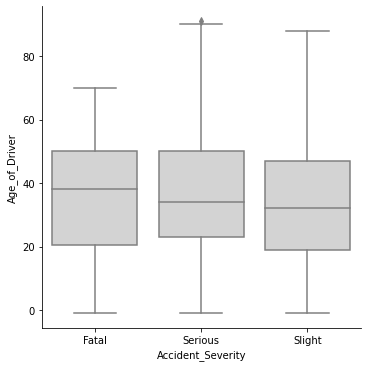

In [37]:
vehicles_accidents = pd.merge(sheffield_data["vehicles"], sheffield_data["accidents"], on=["Accident_Index", "Accident_Index"])
sns.catplot(x='Accident_Severity', y='Age_of_Driver', kind="box", data=vehicles_accidents,  height= 5, color='lightgray')
plt.xticks(plt.xticks()[0], ['Fatal', 'Serious', 'Slight']);

In [38]:
mask_age2 = (sheffield_data['casualties']['Age_of_Casualty']>=0)
AgeCasualty = sheffield_data['casualties']["Age_of_Casualty"][mask_age2]
AgeCasualty = AgeCasualty.to_frame()

AgeCasualty.describe()

Age_of_Casualty
count      1155.000000
mean         37.101299
std          19.469728
min           0.000000
25%          22.000000
50%          34.000000
75%          50.000000
max          91.000000

In [40]:
#sns.boxplot(AgeCasualty, width=0.5, color='lightgray').set_title('Age of the Casualty in an accident');

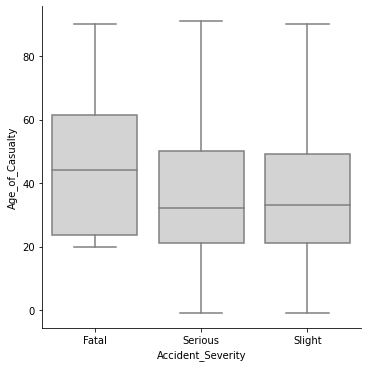

In [41]:
casualties_accidents = pd.merge(sheffield_data["casualties"], sheffield_data["accidents"], on=["Accident_Index", "Accident_Index"])
sns.catplot(x='Accident_Severity', y='Age_of_Casualty', kind="box", data=casualties_accidents,  height= 5, color='lightgray')
plt.xticks(plt.xticks()[0], ['Fatal', 'Serious', 'Slight']);

### Frequency Histogram

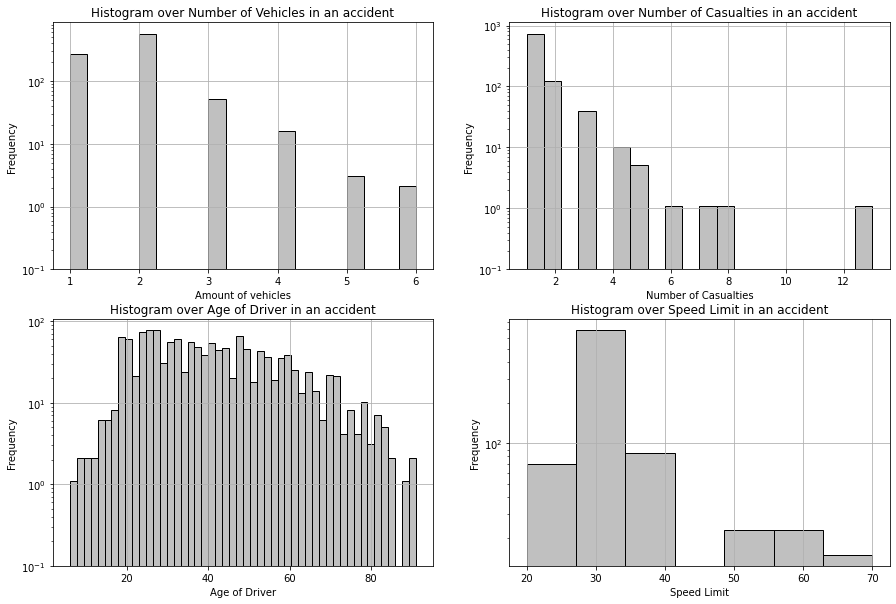

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
mask = (sheffield_data["vehicles"]["Age_of_Driver"] >=0)
sheffield_data["accidents"]["Number_of_Vehicles"].hist(ax=ax[0,0], bins=20, bottom=0.1,color = 'silver',edgecolor = 'black')
sheffield_data["accidents"]["Speed_limit"].hist(ax=ax[1,1], bins=7,color = 'silver',edgecolor = 'black');
sheffield_data["accidents"]["Number_of_Casualties"].hist(ax=ax[0,1], bins=20, bottom=0.1,color = 'silver',edgecolor = 'black')
sheffield_data["vehicles"]["Age_of_Driver"][mask].hist(ax=ax[1,0], bins=50, bottom=0.1,color = 'silver',edgecolor = 'black')

ax[0,0].set_title('Histogram over Number of Vehicles in an accident')
ax[1,1].set_title('Histogram over Speed Limit in an accident')
ax[0,1].set_title('Histogram over Number of Casualties in an accident')
ax[1,0].set_title('Histogram over Age of Driver in an accident')

ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')
ax[0,1].set_ylabel('Frequency')
ax[1,1].set_ylabel('Frequency')

ax[0,0].set_xlabel('Amount of vehicles')
ax[1,1].set_xlabel('Speed Limit')
ax[0,1].set_xlabel('Number of Casualties')
ax[1,0].set_xlabel('Age of Driver')

ax[0,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
plt.plot();

### Frequency Barplot

In [43]:
AS_count = sheffield_data["accidents"]["Accident_Severity"].value_counts()
AS_unq = sheffield_data["accidents"]["Accident_Severity"].unique()

RT = sheffield_data["accidents"]["Road_Type"][(sheffield_data["accidents"]["Road_Type"] >0)]
RT_count = RT.value_counts()
RT_unq = [1,2,3,4,5,6]

sex = sheffield_data["vehicles"]["Sex_of_Driver"][(sheffield_data["vehicles"]["Sex_of_Driver"] >0)]
sex_counts = sex.value_counts()
sex_unq = sex.unique()

CC_counts = sheffield_data["casualties"]["Casualty_Class"].value_counts()
CC_unq = sheffield_data["casualties"]["Casualty_Class"].unique()

mask = (sheffield_data["vehicles"]["1st_Point_of_Impact"] >= 0)
PoI_counts = sheffield_data["vehicles"]["1st_Point_of_Impact"][mask].value_counts()
PoI_unq = sheffield_data["vehicles"]["1st_Point_of_Impact"][mask].unique()


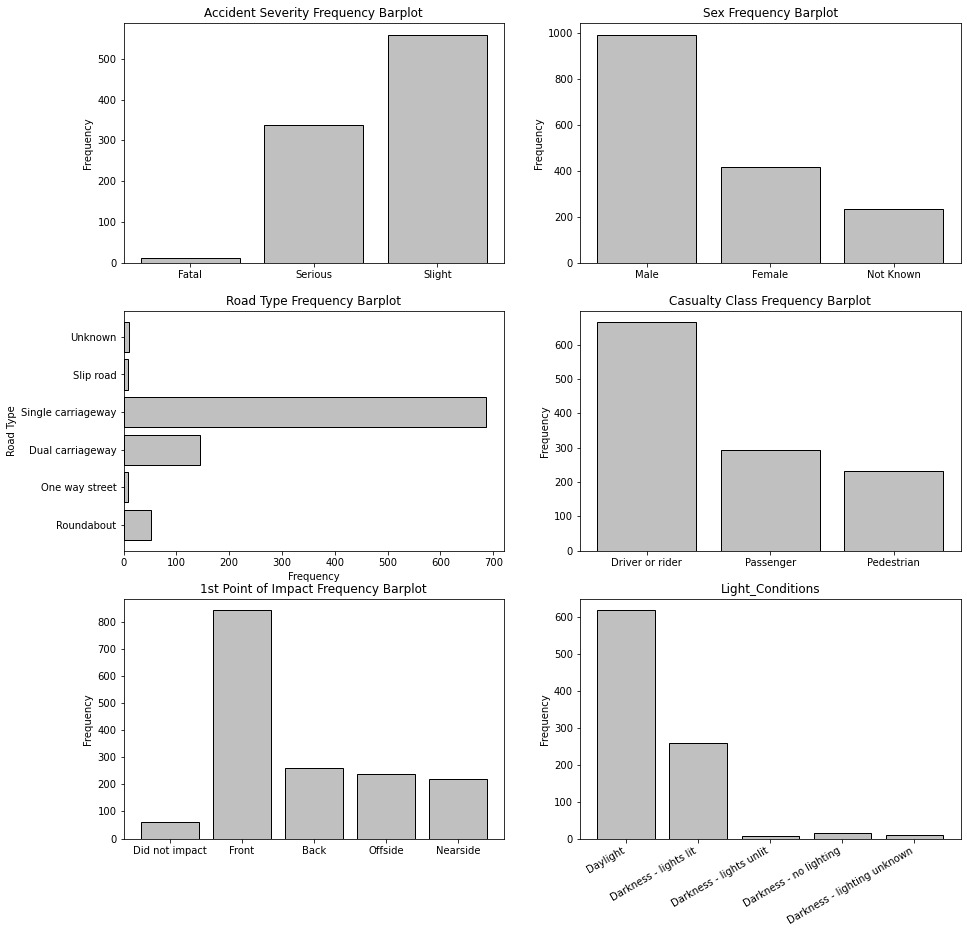

In [44]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

ax[0,0].set_title("Accident Severity Frequency Barplot")
ax[0,0].set_ylabel("Frequency")
ax[0,0].bar(sorted(AS_unq), sorted(AS_count), tick_label = ["Fatal", "Serious", "Slight"],color = 'silver',edgecolor = 'black')

ax[1,0].set_title("Road Type Frequency Barplot")
ax[1,0].set_ylabel("Road Type")
ax[1,0].set_xlabel("Frequency")
l = ["Roundabout", "One way street", "Dual carriageway","Single carriageway", "Slip road", "Unknown"]  
ax[1,0].barh(sorted(RT_unq), RT_count.sort_index(), tick_label = l,color = 'silver',edgecolor = 'black')
#ax[2].bar(sorted(ac3_unq), ac3_counts.sort_index());
                                                                                                                        


ax[0,1].set_title("Sex Frequency Barplot")
ax[0,1].set_ylabel("Frequency")
ax[0,1].bar(sorted(sex_unq), sex_counts, tick_label = ["Male","Female","Not Known"],color = 'silver',edgecolor = 'black')


ax[1,1].set_title("Casualty Class Frequency Barplot")
ax[1,1].set_ylabel("Frequency")
ax[1,1].bar(sorted(CC_unq), CC_counts, tick_label = ["Driver or rider", "Passenger", "Pedestrian"],color = 'silver',edgecolor = 'black')


ax[2,0].set_title("1st Point of Impact Frequency Barplot")
ax[2,0].set_ylabel("Frequency")
ax[2,0].bar(sorted(PoI_unq), PoI_counts.sort_index(), tick_label = ["Did not impact", "Front", "Back","Offside", "Nearside"], color = 'silver',edgecolor = 'black')


field_name = "Light_Conditions"
field_categories = {1: "Daylight", 4: "Darkness - lights lit", 5: "Darkness - lights unlit", 6: "Darkness - no lighting", 7: "Darkness - lighting unknown"}

ax[2,1].set_title(field_name)
ax[2,1].set_ylabel("Frequency")

light = sheffield_data["accidents"][field_name][(sheffield_data["accidents"]["Light_Conditions"] !=-1)]
light_counts = light.value_counts()
categories, counts = np.unique(sheffield_data["accidents"][field_name], return_counts=True)

ax[2,1].set_xticks(range(len(categories)))
ax[2,1].set_xticklabels(field_categories.values());

ax[2,1].bar(range(len(categories)), light_counts.sort_index(), color = 'silver',edgecolor = 'black')

plt.setp(ax[2,1].get_xticklabels(), rotation=30, ha='right')

plt.plot();

### Weather Conditions Barh

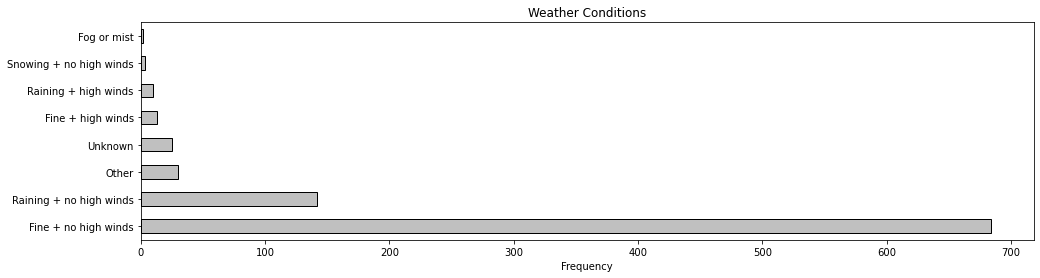

In [45]:
accident_weather = sheffield_data['accidents']['Weather_Conditions']
counts1 = accident_weather.value_counts()



fig,axes = plt.subplots(figsize =(16,4))
counts1.plot.barh(color = 'silver',edgecolor = 'black',rot = 0)
axes.set_title('Weather Conditions')
axes.set_xlabel('Frequency');

list_weather = ['Fine + no high winds',
'Raining + no high winds',
'Other',
'Unknown',
'Fine + high winds',
'Raining + high winds',
'Snowing + no high winds',
'Fog or mist']
axes.set_yticklabels(list_weather);

### Frequency Barh for Junction Location

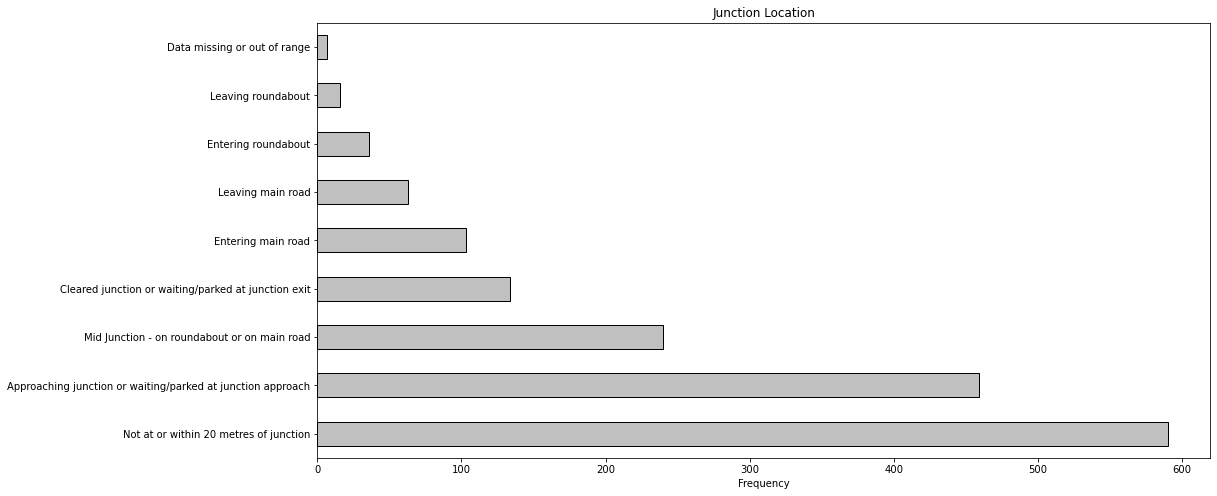

In [46]:
bb = sheffield_data['vehicles']['Junction_Location'] 
bb1 = bb.value_counts() 
fig,ax = plt.subplots(figsize = (16,8)) 
bb1.plot.barh(color = 'silver',edgecolor = 'black',rot = 0)
ax.set_title('Junction Location')
ax.set_xlabel('Frequency');

list_final = ['Not at or within 20 metres of junction',
             'Approaching junction or waiting/parked at junction approach',
             'Mid Junction - on roundabout or on main road',
             'Cleared junction or waiting/parked at junction exit',
             'Entering main road',
             'Leaving main road',
             'Entering roundabout',
             'Leaving roundabout',
             'Data missing or out of range']

ax.set_yticklabels(list_final);

# Task 1 - Single variable analysis


### Report the frequency of road collisions in your city for 

1. different age groups 
2. in different times (during the day, the week, or year)
3. and for differences in one other condition.


#### Different age groups

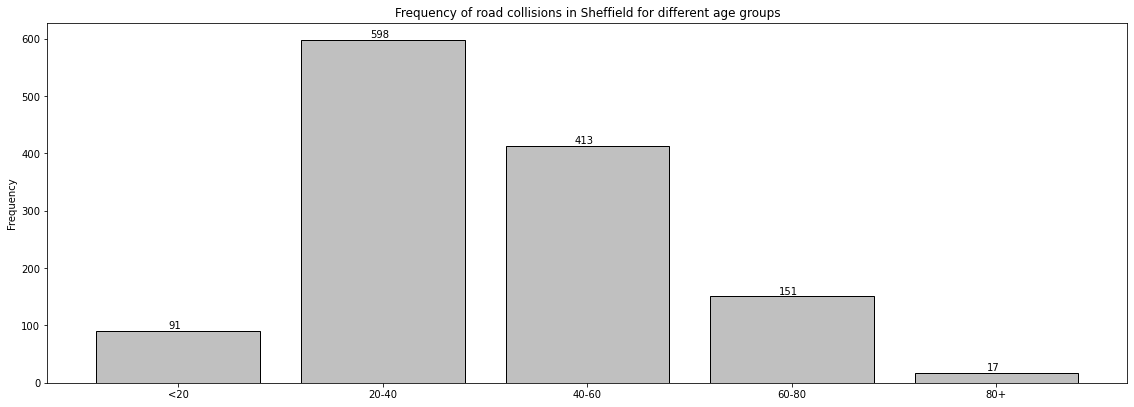

In [47]:
mask_age = (sheffield_data["vehicles"]["Age_of_Driver"] >= 0)
AoD = sheffield_data["vehicles"]["Age_of_Driver"][mask_age]


l = []
mask = (sheffield_data["vehicles"]["Age_of_Driver"] <20)

l.append(AoD[mask].shape[0])
mask = (sheffield_data["vehicles"]["Age_of_Driver"] >20) & (sheffield_data["vehicles"]["Age_of_Driver"] <40)
l.append(AoD[mask].shape[0])
mask = (sheffield_data["vehicles"]["Age_of_Driver"] >40) & (sheffield_data["vehicles"]["Age_of_Driver"] <60)
l.append(AoD[mask].shape[0])
mask = (sheffield_data["vehicles"]["Age_of_Driver"] >60) & (sheffield_data["vehicles"]["Age_of_Driver"] <80)
l.append(AoD[mask].shape[0])
mask = (sheffield_data["vehicles"]["Age_of_Driver"] >80)
l.append(AoD[mask].shape[0])

fig = plt.figure(figsize=(15,5))
axes = fig.add_axes([0,0,1,1])
axes.set_title("Frequency of road collisions in Sheffield for different age groups")
axes.set_ylabel("Frequency")
interval = ["<20",'20-40', '40-60', '60-80', '80+']
axes.bar(interval, l,color = 'silver',edgecolor = 'black')

for index,value in enumerate(l):
    axes.text(index - 0.015, value + 0.05,str(value),ha='center', va='bottom')

plt.plot();

#### Different times

##### Day

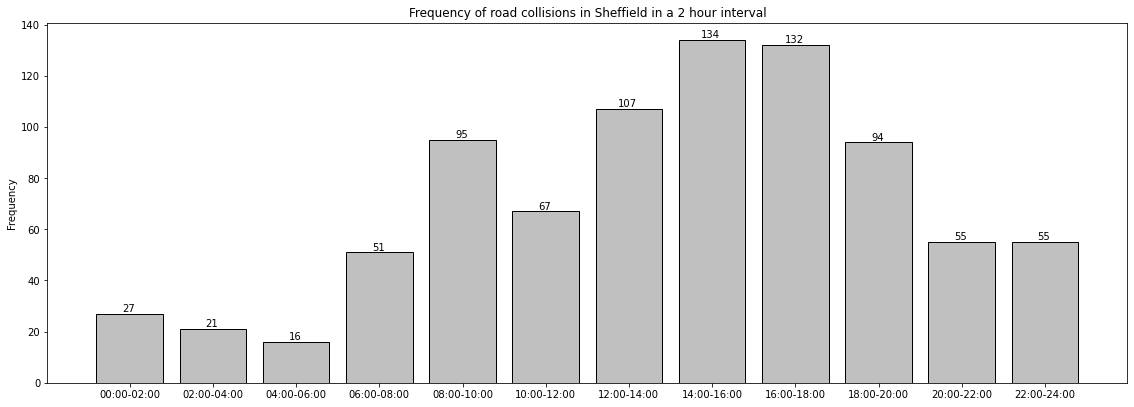

In [48]:
l = [['00:00', '02:00'], 
     ['02:00', '04:00'], 
     ['04:00', '06:00'], 
     ['06:00', '08:00'], 
     ['08:00', '10:00'], 
     ['10:00', '12:00'],
     ['12:00', '14:00'], 
     ['14:00', '16:00'], 
     ['16:00', '18:00'], 
     ['18:00', '20:00'], 
     ['20:00', '22:00'],
     ['22:00', '24:00']]

empty = []
for i in range(0,12):
    mask = (sheffield_data["accidents"]["Time"] < l[i][1]) & (sheffield_data["accidents"]["Time"] > l[i][0])
    total = len(sheffield_data["accidents"][mask]["Time"])
    empty.append(total)
    
fig = plt.figure(figsize=(15,5))
axes = fig.add_axes([0,0,1,1])
axes.set_title("Frequency of road collisions in Sheffield in a 2 hour interval")
axes.set_ylabel("Frequency")
interval = ["00:00-02:00",'02:00-04:00', '04:00-06:00', '06:00-08:00', '08:00-10:00', '10:00-12:00',
                 '12:00-14:00','14:00-16:00', '16:00-18:00', '18:00-20:00', '20:00-22:00', '22:00-24:00']
axes.bar(interval, empty,color = 'silver',edgecolor = 'black');
for index,value in enumerate(empty):
    axes.text(index - 0.015, value + 0.05,str(value),ha='center', va='bottom')
    


plt.savefig('stuff')

##### Week

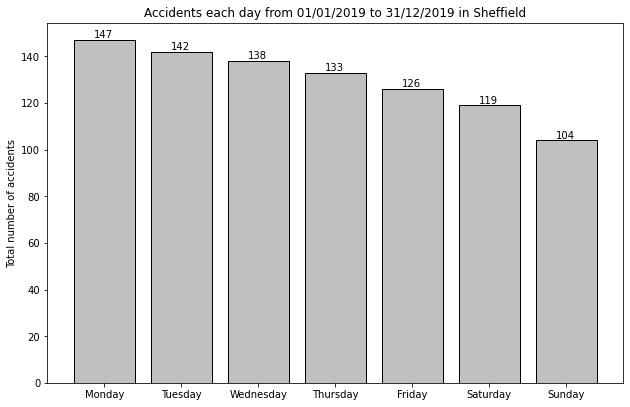

In [49]:
week = ["Monday", "Tuesday", "Wednesday","Thursday","Friday", "Saturday", "Sunday"]
unq = sheffield_data["accidents"]["Day_of_Week"].unique()
count = sheffield_data["accidents"]["Day_of_Week"].value_counts()
fig = plt.figure(figsize=(8, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_title("Accidents each day from 01/01/2019 to 31/12/2019 in Sheffield")
axes.set_ylabel("Total number of accidents")
axes.bar(sorted(unq), count, tick_label = week,color = 'silver',edgecolor = 'black')

for index,value in enumerate(count):
    axes.text(index + 1 - 0.015, value + 0.05,str(value),ha='center', va='bottom')
    

plt.plot();

##### Year

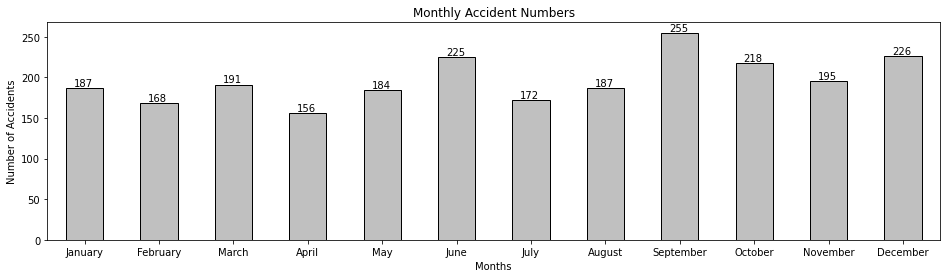

In [50]:
list_month = [
'January',
'February',
'March',
'April',
'May',
'June',
'July',
'August',
'September',
'October',
'November',
'December'
]
accident_severity = sheffield_data['accidents']['Accident_Severity']
accident_dates = pd.to_datetime(sheffield_data['accidents']['Date'])
a = accident_severity.groupby(accident_dates.dt.month).sum()
fig,ax = plt.subplots(figsize = (16,4))
a.plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
ax.set_title('Monthly Accident Numbers')
ax.set_xlabel('Months')
ax.set_ylabel('Number of Accidents')
ax.set_xticklabels(list_month)
for index,value in enumerate(a):
    ax.text(index - 0.015, value + 0.05,str(value),ha='center', va='bottom')

##### Number of accidents each day   

In [51]:
#COUNTING THE ACCIDENTS EACH DAY IN EVERY MONTH

accident_severity = sheffield_data['accidents']['Accident_Severity']

accident_dates = pd.to_datetime(sheffield_data['accidents']['Date'])

accident_dates1 = accident_dates.dt.date



mask = (accident_dates > "2019-12-01") & (accident_dates <= "2019-12-31")
s = accident_dates1[mask].value_counts()
s1 = pd.DataFrame(s)
s1.columns = ['Accidents']
print(s1.to_markdown(tablefmt = 'github'))

|            |   Accidents |
|------------|-------------|
| 2019-12-13 |           8 |
| 2019-12-17 |           6 |
| 2019-12-10 |           5 |
| 2019-12-09 |           5 |
| 2019-12-07 |           4 |
| 2019-12-15 |           4 |
| 2019-12-20 |           4 |
| 2019-12-30 |           4 |
| 2019-12-24 |           3 |
| 2019-12-16 |           3 |
| 2019-12-06 |           3 |
| 2019-12-04 |           3 |
| 2019-12-22 |           3 |
| 2019-12-03 |           3 |
| 2019-12-31 |           2 |
| 2019-12-12 |           2 |
| 2019-12-18 |           2 |
| 2019-12-11 |           2 |
| 2019-12-19 |           2 |
| 2019-12-08 |           2 |
| 2019-12-21 |           2 |
| 2019-12-05 |           2 |
| 2019-12-02 |           2 |
| 2019-12-23 |           1 |
| 2019-12-25 |           1 |
| 2019-12-27 |           1 |
| 2019-12-28 |           1 |
| 2019-12-14 |           1 |
| 2019-12-29 |           1 |


##### Monthly Accident Severity

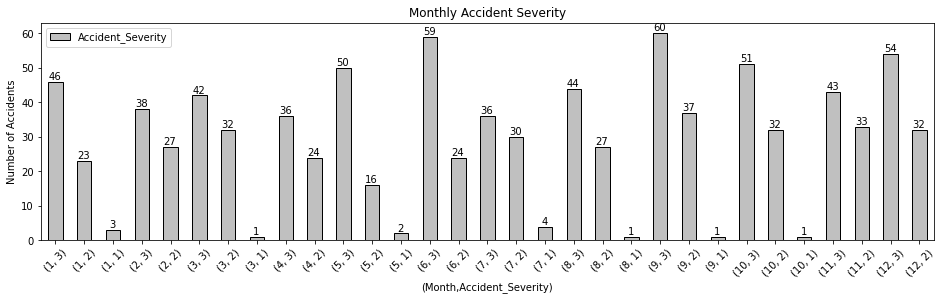

In [52]:
#####MONTHLY SEVERITY 2
accident_severity = sheffield_data['accidents']['Accident_Severity']
accident_dates = pd.to_datetime(sheffield_data['accidents']['Date'])
#accident_severity.groupby(accident_dates.dt.month).count().plot(kind="bar")
a = accident_severity.groupby(accident_dates.dt.month)
a1 = a.value_counts()

fig,ax = plt.subplots(figsize = (16,4))
a1.plot.bar(color = 'silver',edgecolor = 'black',rot = 45)
ax.set_title('Monthly Accident Severity')
ax.set_xlabel('(Month,Accident_Severity)')
ax.set_ylabel('Number of Accidents')
ax.legend(loc = "upper left")
for index,value in enumerate(a1):
    ax.text(index - 0.015, value + 0.05,str(value),ha='center', va='bottom')

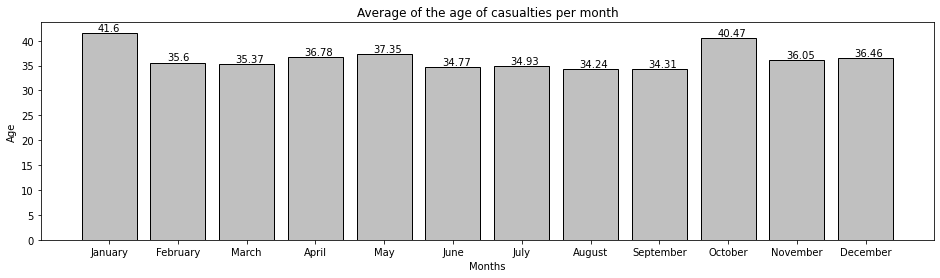

In [53]:
casualty_age1 = sheffield_data['casualties']['Age_of_Casualty']
casualty_index = sheffield_data['casualties']['Accident_Index']
accident_dates = pd.to_datetime(sheffield_data['accidents']['Date'])
accident_dates2 = list(accident_dates.dt.month)


dict1 = dict()
casualty_age2 = list(casualty_age1)
casualty_index1 = list(casualty_index)

for i in range(len(casualty_index1)):
    for j in range(len(casualty_age2)):
        if i == j:
            dict1.setdefault(casualty_index1[i],[]).append(casualty_age2[j])
            

dataframe1 = pd.DataFrame(list(dict1.items()))
df2 = (dataframe1[1])



dict_final = dict()
for x in range(len(accident_dates2)):
    for z in range(len(df2)):
        if x == z:
            dict_final.setdefault(accident_dates2[x],[]).append(df2[z])

dict_plot = dict()

def monthly_mean(var):
    for i,j in dict_final.items():
        for z in j:
            if i == var :
                dict_plot.setdefault(i,[]).append(np.mean(z))
    return dict_plot

for i in range(1,13):
    monthly_mean(i)

for i,j in dict_plot.items():
    dict_plot[i] = np.mean(j)
    


list_month = [
'January',
'February',
'March',
'April',
'May',
'June',
'July',
'August',
'September',
'October',
'November',
'December'
]



#PLOT    
fig1,ax1 = plt.subplots(figsize = (16,4))
ax1.bar(dict_plot.keys(),dict_plot.values(),color = 'silver',edgecolor = 'black')
ax1.set_xticks(range(1,13))
ax1.set_title('Average of the age of casualties per month')
ax1.set_xlabel('Months')
ax1.set_ylabel('Age')
ax1.set_xticklabels(list_month);


rounded_list = [round(i,2) for i in dict_plot.values()]
for index,value in enumerate(rounded_list):
    ax1.text(index + 0.84, value + 0,str(value),ha='left', va='bottom')


# Task 2 - Associations


## Research whether there is a significant statistical association in your city, either
1. between some vehicle attributes and accident circumstances, or 
2. between some casualty attributes and accident circumstances. 

Report whether there is a statistically significant association between such variables or not, together with the appropriate statistical metric(s).
 
Discuss why this association, or the lack of
this association, is relevant for urban/transport planning.

### Speed limit and Accident Severity

chival is: 14.437707863891468
p value is 0.15394604778168805and thus is: 
Independent (H0 holds true)
df is: 10
N is: 909
V: 0.08911528195819253 a value close to 0 means weak, close to 1 means strong


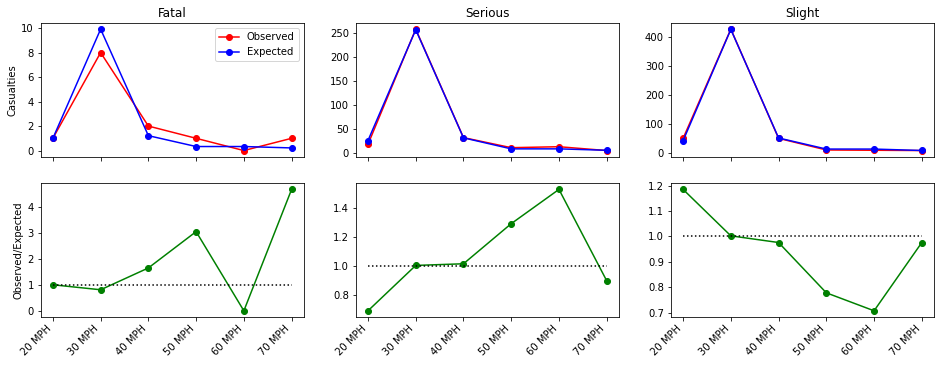

In [54]:
mask = (sheffield_data["accidents"]["Speed_limit"] != -1)
severityspeed = np.array([sheffield_data["accidents"]["Speed_limit"][mask], sheffield_data["accidents"]["Accident_Severity"][mask]]).T
observed_pd = pd.crosstab(severityspeed[:, 0], severityspeed[:, 1], rownames = ["Speed limit"], colnames = ["Accident Severity"]) 
observed_pd_n = pd.crosstab(severityspeed[:, 0], severityspeed[:, 1], rownames = ["Speed limit"], colnames = ["Accident Severity"], normalize = True) 
observed = observed_pd.to_numpy()

chiVal, pVal, df, expected = chi2_contingency(observed)

print("chival is: {}".format(chiVal))

alpha = 0.05
print("p value is " + str(pVal) + "and thus is: ") 
if pVal <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')

print("df is: {}".format(df))

N = observed.sum(axis = 1).sum()
print('N is:' , N)

V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
print("V: "+ str(V) + " a value close to 0 means weak, close to 1 means strong")

## Plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

severity_labels = ["Fatal", "Serious", "Slight"]
speed_categories = {20: "20 MPH", 30: "30 MPH", 40: "40 MPH", 50: "50 MPH", 60: "60 MPH", 70: "70 MPH"}
x = np.array(list(speed_categories.keys()))

for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[:,i], 'ro-', label='Observed')
    ax.plot(x, expected[:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Casualties')
        ax.legend(loc='best');
    ax.set_title(severity_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(speed_categories.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[:,i]/expected[:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(speed_categories.values()))
    fig.autofmt_xdate(rotation=45)

Since pVal > 0.1 the association between speed limit and accident severity in Sheffield is not significant. 

### Accident severity and road type

p value is 0.5710736711026121
Independent (H0 holds true)
V: 0.06875213481103486 a value close to 0 means weak, close to 1 means strong


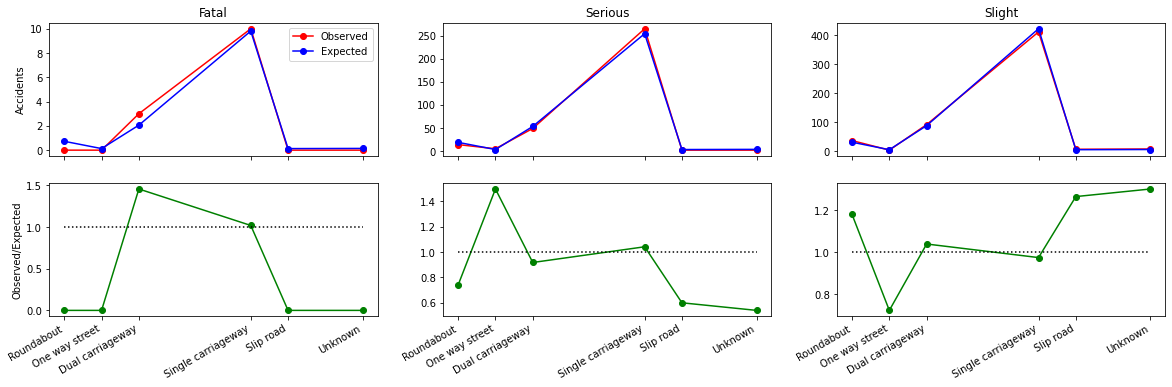

In [55]:
mask = (sheffield_data["accidents"]["Road_Type"] != -1)
severityRoad = np.array([sheffield_data["accidents"]["Road_Type"][mask], sheffield_data["accidents"]["Accident_Severity"][mask]]).T
observed_pd = pd.crosstab(severityRoad[:, 0], severityRoad[:, 1], rownames = ["Road Type"], colnames = ["Accident Severity"]) 
observed_pd_n = pd.crosstab(severityRoad[:, 0], severityRoad[:, 1], rownames = ["Road Type"], colnames = ["Accident Severity"], normalize = True) 
observed = observed_pd.to_numpy()

chiVal, pVal, df, expected = chi2_contingency(observed)

alpha = 0.05
print("p value is " + str(pVal)) 
if pVal <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')
    
N = observed.sum(axis = 1).sum()    

V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
print("V: "+ str(V) + " a value close to 0 means weak, close to 1 means strong")

##Plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 6))

severity_labels = ["Fatal", "Serious", "Slight"]
road_categories = {1: "Roundabout", 2: "One way street", 3: "Dual carriageway", 6: "Single carriageway", 7: "Slip road", 9: "Unknown"}
x = np.array(list(road_categories.keys()))

for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[:,i], 'ro-', label='Observed')
    ax.plot(x, expected[:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Accidents')
        ax.legend(loc='best');
    ax.set_title(severity_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(road_categories.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[:,i]/expected[:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(road_categories.values()))
    fig.autofmt_xdate(rotation=30)

### Road Type and Light Conditions

p value is 2.4397023007726356e-07
Dependent (reject H0)
V: 0.14925830779810723 a value close to 0 means weak, close to 1 means strong


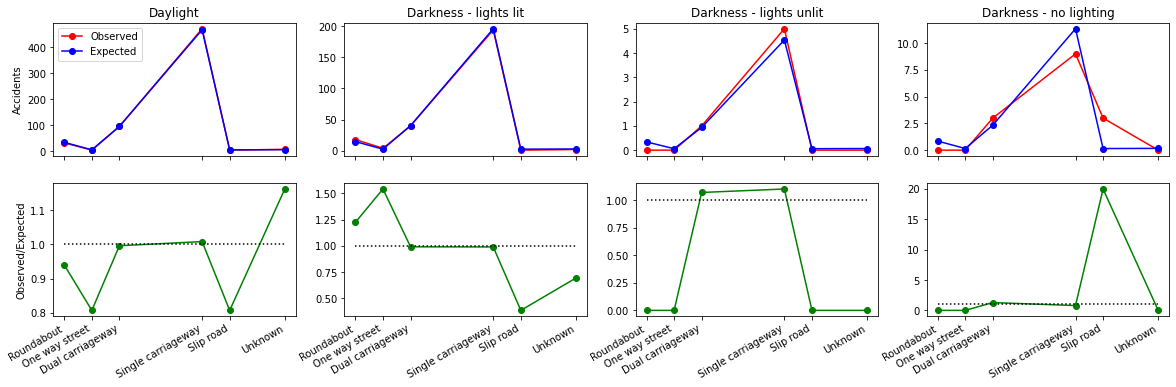

In [56]:
mask = (sheffield_data["accidents"]["Road_Type"] != -1
       ) & (sheffield_data["accidents"]["Light_Conditions"] != -1
       ) & (sheffield_data["accidents"]["Light_Conditions"] != 7)
lightRoad = np.array([sheffield_data["accidents"]["Road_Type"][mask], 
                      sheffield_data["accidents"]["Light_Conditions"][mask]]).T

observed_pd = pd.crosstab(lightRoad[:, 0], lightRoad[:, 1], 
                          rownames = ["Road Type"], colnames = ["Light Conditions"]) 

observed_pd_n = pd.crosstab(lightRoad[:, 0], lightRoad[:, 1], 
                            rownames = ["Road Type"], colnames = ["Light Conditions"], normalize = True) 

observed = observed_pd.to_numpy()

chiVal, pVal, df, expected = chi2_contingency(observed)

alpha = 0.05
print("p value is " + str(pVal)) 
if pVal <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')
    
N = observed.sum(axis = 1).sum()    

V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
print("V: "+ str(V) + " a value close to 0 means weak, close to 1 means strong")

##Plots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 6))

light_labels = ["Daylight", "Darkness - lights lit", "Darkness - lights unlit", "Darkness - no lighting", "Darkness - lighting unknown"]
road_categories = {1: "Roundabout", 2: "One way street", 3: "Dual carriageway", 6: "Single carriageway", 7: "Slip road", 9: "Unknown"}
x = np.array(list(road_categories.keys()))

for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[:,i], 'ro-', label='Observed')
    ax.plot(x, expected[:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Accidents')
        ax.legend(loc='best');
    ax.set_title(light_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(road_categories.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[:,i]/expected[:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(road_categories.values()))
    fig.autofmt_xdate(rotation=30)

### Casualty Class and Accident Severity

chival is: 23.325082682868068
p value is 0.00010902937605065993
Dependent (reject H0)
df is: 4
N is: 1191
V: 0.09895567769107427 a value close to 0 means weak, close to 1 means strong


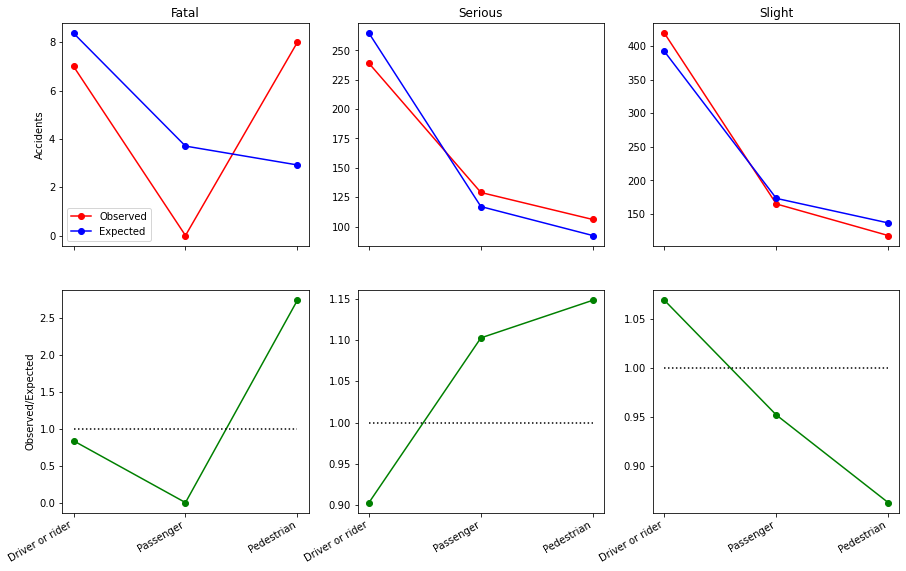

In [57]:
mask = (casualties_accidents["Casualty_Class"] != -1
       ) & (casualties_accidents["Accident_Severity"] !=-1
       ) 
Cas_Sev = np.array([casualties_accidents["Casualty_Class"][mask], 
                      casualties_accidents["Accident_Severity"][mask]]).T

observed_pd = pd.crosstab(Cas_Sev[:, 0], Cas_Sev[:, 1], 
                          rownames = ["Casualty_Class"], colnames = ["Accident_Severity"]) 

observed_pd_n = pd.crosstab(Cas_Sev[:, 0], Cas_Sev[:, 1], 
                            rownames = ["Casualty_Class"], colnames = ["Accident_Severity"], normalize = True) 

observed = observed_pd.to_numpy()

chiVal, pVal, df, expected = chi2_contingency(observed)
#print(chiVal, pVal, df, expected.astype(int))

print("chival is: {}".format(chiVal))

alpha = 0.05
print("p value is " + str(pVal)) 
if pVal <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')

print("df is: {}".format(df))

N = observed.sum(axis = 1).sum()
print('N is:' , N)

V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
print("V: "+ str(V) + " a value close to 0 means weak, close to 1 means strong")

##Plots

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
severity_labels = ["Fatal", "Serious", "Slight"]
casualty_classes = {1: "Driver or rider", 2: "Passenger", 3: "Pedestrian"}

x = np.array(list(casualty_classes.keys()))


for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[:,i], 'ro-', label='Observed')
    ax.plot(x, expected[:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Accidents')
        ax.legend(loc='best');
    ax.set_title(severity_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(casualty_classes.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[:,i]/expected[:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(casualty_classes.values()))
    fig.autofmt_xdate(rotation=30)

An association only tells us about correlation, not causation. However, in this case, there is good reason to say that a pedestrian is more likely to suffer a fatal or serious accident. Although Cramer's V is low, there is a very clear effect, especially for fatal and serious collisions,  𝜒2 (4(degree of freedom), N(number of records) = 1191

The conclusion is therefore:
Fatal accidents are over 2,5 times more likely than expected for pedestrians, and are 2-3 times less likely than expected for Drivers. An urban planning policy recommendation could therefore be: To make city streets safer for pedestrians.

### Accident severity and junction location

chival is: 15.4114810927458
p value is 0.35061730329298313
Independent (H0 holds true)
df is: 14
N is: 1641
V: 0.06852560847362556 a value close to 0 means weak, close to 1 means strong


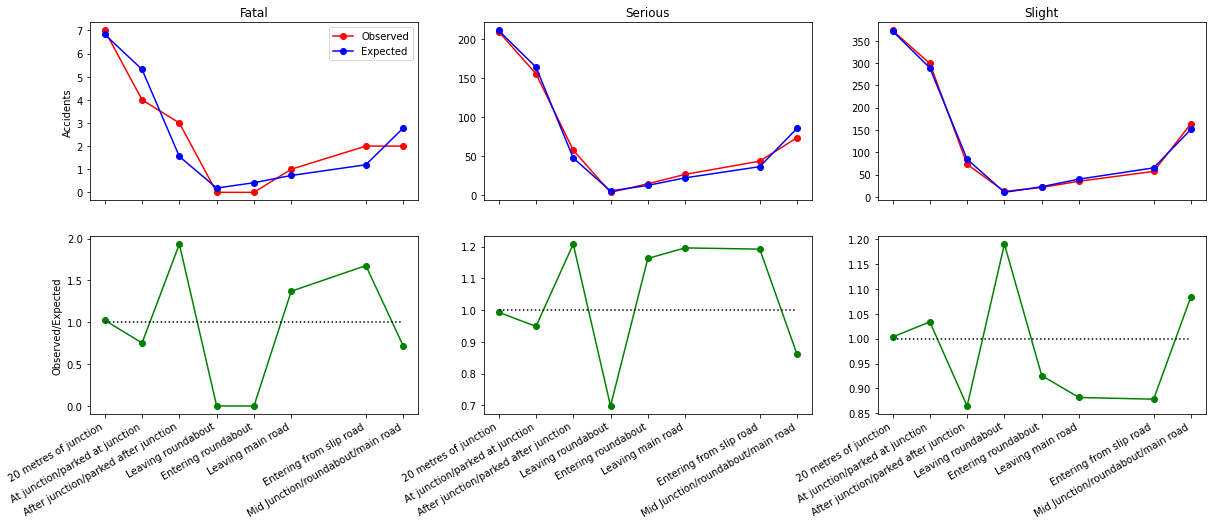

In [58]:
mask = (vehicles_accidents["Junction_Location"] != -1)

junctionAccident = np.array([vehicles_accidents["Junction_Location"][mask],
                             vehicles_accidents["Accident_Severity"][mask]]).T

observed_pd = pd.crosstab(junctionAccident[:, 0], junctionAccident[:, 1], 
                          rownames = ["Junction_Location"], colnames = ["Accident_Severity"]) 

observed_pd_n = pd.crosstab(junctionAccident[:, 0], junctionAccident[:, 1], 
                            rownames = ["Junction_Location"], colnames = ["Accident_Severity"], normalize = True) 

observed = observed_pd.to_numpy()

chiVal, pVal, df, expected = chi2_contingency(observed)



print("chival is: {}".format(chiVal))

alpha = 0.05
print("p value is " + str(pVal)) 
if pVal <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')

print("df is: {}".format(df))

N = observed.sum(axis = 1).sum()
print('N is:' , N)

V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
print("V: "+ str(V) + " a value close to 0 means weak, close to 1 means strong")

##Plots

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
severity_labels = ["Fatal", "Serious", "Slight"]

junction_categories = {0: '20 metres of junction',
                       1: 'At junction/parked at junction', 
                       2: 'After junction/parked after junction', 
                       3: 'Leaving roundabout', 
                       4: 'Entering roundabout', 
                       5: 'Leaving main road',
                       7: 'Entering from slip road',
                       8: 'Mid Junction/roundabout/main road'}


casualty_classes = {1: "Driver or rider", 2: "Passenger", 3: "Pedestrian"}

x = np.array(list(junction_categories.keys()))


for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[:,i], 'ro-', label='Observed')
    ax.plot(x, expected[:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Accidents')
        ax.legend(loc='best');
    ax.set_title(severity_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(junction_categories.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[:,i]/expected[:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(junction_categories.values()))
    fig.autofmt_xdate(rotation=30)

### Accident severity and Police officer attendance

chival is: 63.01323997197869
p value is 2.0741912443096066e-14
Dependent (reject H0)
df is: 2
N is: 909
V: 0.2632897569575931 a value close to 0 means weak, close to 1 means strong


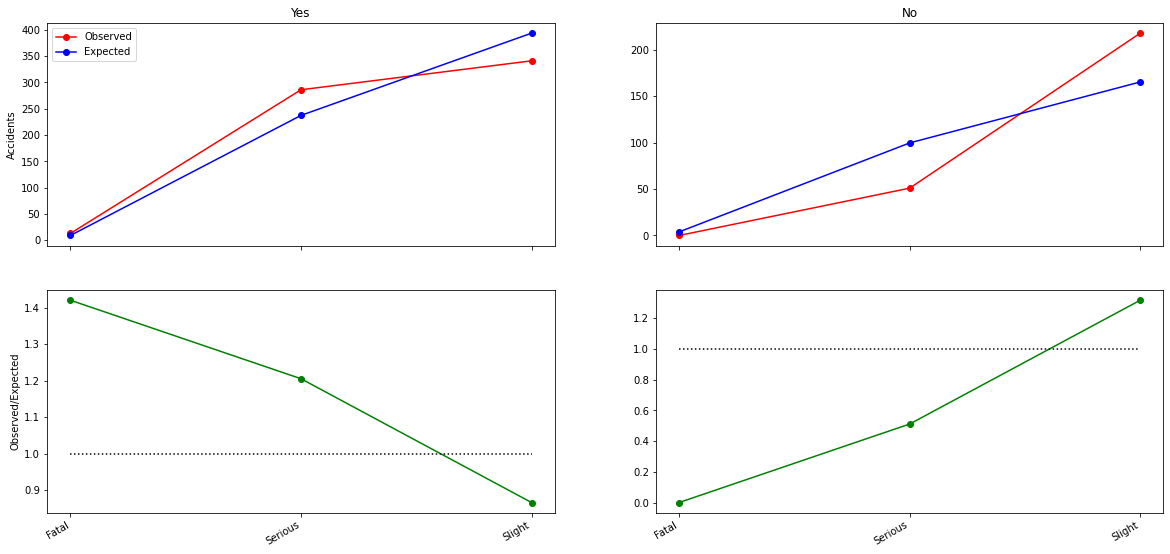

In [59]:
PoliceSeverity = np.array([sheffield_data["accidents"]["Did_Police_Officer_Attend_Scene_of_Accident"], 
                      sheffield_data["accidents"]["Accident_Severity"]]).T

observed_pd = pd.crosstab(PoliceSeverity[:, 0], PoliceSeverity[:, 1], 
                          rownames = ["Police officer attendance"] , colnames = ["Accident Severity"]) 

observed_pd_n = pd.crosstab(PoliceSeverity[:, 0], PoliceSeverity[:, 1], 
                            rownames = ["Accident Severity"], colnames = ["Police officer attendance"], normalize = True) 

observed = observed_pd.to_numpy()

chiVal, pVal, df, expected = chi2_contingency(observed)

print("chival is: {}".format(chiVal))

alpha = 0.05
print("p value is " + str(pVal)) 
if pVal <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')

print("df is: {}".format(df))

N = observed.sum(axis = 1).sum()
print('N is:' , N)

V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
print("V: "+ str(V) + " a value close to 0 means weak, close to 1 means strong")

##Plots

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

police_categories = ['Yes', 'No']
accident_labels = {1: "Fatal", 2: "Serious", 3: "Slight"}
Accident_categories = ["Fatal", "Serious", "Slight"]
police_labels = {1: "Yes", 2: "No"}

x = np.array(list(accident_labels.keys()))


for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[i], 'ro-', label='Observed')
    ax.plot(x, expected[i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Accidents')
        ax.legend(loc='best');
    ax.set_title(police_categories[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(accident_labels.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[i]/expected[i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(accident_labels.values()))
    fig.autofmt_xdate(rotation=30)

### Visualizing the association between casualty severity, class and age

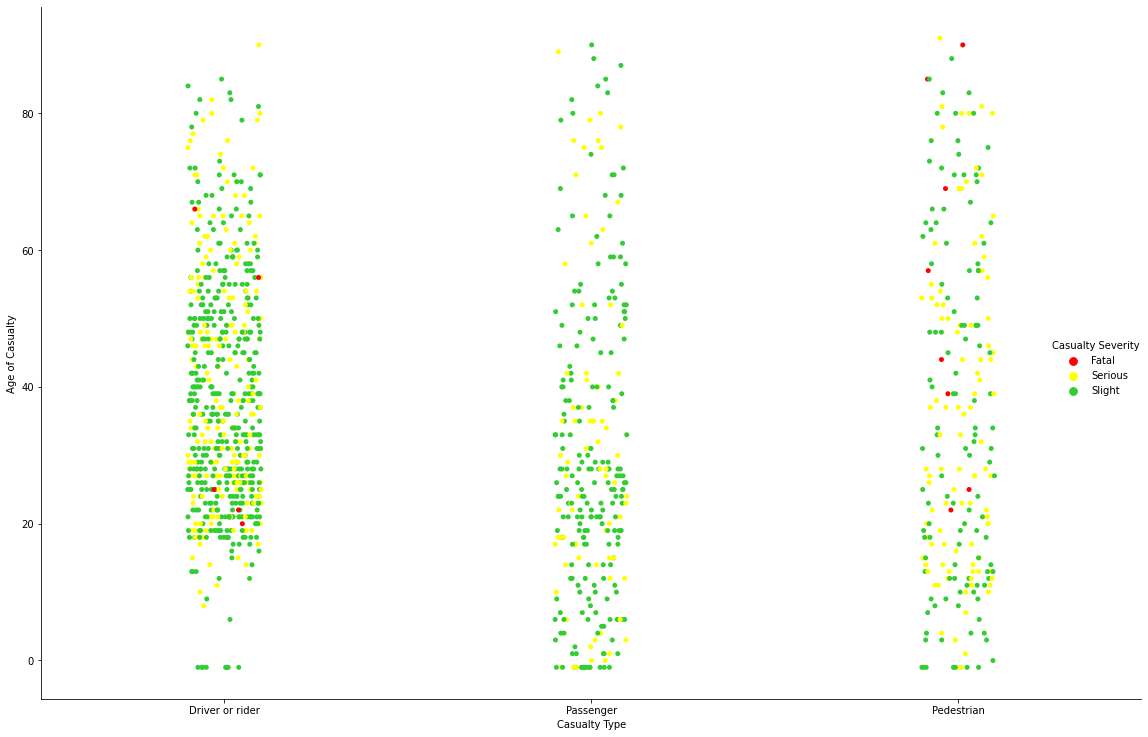

In [60]:
casualty_class = sheffield_data['casualties']['Casualty_Class']
casualty_severity = sheffield_data['casualties']['Casualty_Severity']
casualty_age = sheffield_data['casualties']['Age_of_Casualty']
data1 = np.array([casualty_class,casualty_age,casualty_severity]).T
ax = sns.catplot(x='Casualty Type', y='Age of Casualty', hue='Casualty Severity',data=pd.DataFrame(data1, columns=['Casualty Type', 'Age of Casualty', 'Casualty Severity']),palette = ['Red','Yellow','limegreen']
,kind = 'strip')


ax.fig.subplots_adjust(top=2,right=2.5)
ax.set_xticklabels(["Driver or rider", "Passenger", "Pedestrian"]);



new_title = 'Casualty Severity'
ax._legend.set_title(new_title)

# replace labels
new_labels = ['Fatal', 'Serious','Slight']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l)

plt.savefig("florain stuff")

### Final notes

These assosiations gives us an insigt to various correlations regarding the accidents in Sheffield. The research shows that the speed limit, road type and junction location are independant from the accident severity. This is however only a correlation in the data and not neccecarily a causation. 

# Task 3 - Map visualization

Visualize the reported collisions on a map of your city. Make a visual distinction between different
classes of casualty severity

In [61]:
mask1 = (sheffield_data["accidents"]["Accident_Severity"] == 1)
mask2 = (sheffield_data["accidents"]["Accident_Severity"] == 2)
mask3 = (sheffield_data["accidents"]["Accident_Severity"] == 3)

latlons = np.vstack((sheffield_data["accidents"]['Latitude'], sheffield_data["accidents"]["Longitude"])).T
centroid = list(MultiPoint(latlons).centroid.coords)[0]

m1 = folium.Map(centroid, zoom_start=11)

mask_list = [mask3,mask2,mask1]
color_list = ['green','#ffd800','red']
radius_list = [500, 600, 1500]
opacity_list = [0.5,0.6,1]


for i in range(0,3):
    for row in sheffield_data["accidents"][mask_list[i]].iterrows():
        folium.Circle([row[1][4], row[1][3]], 
                            radius = radius_list[i]/15, 
                            opacity = opacity_list[i],
                            color = color_list[i], 
                            fill=True,
                            fill_opacity=0.3, 
                            popup = "Accident Index: {} \nDate: {} \nTime: {}".format(row[1][0],row[1][9],row[1][11])).add_to(m1)    
        
        

HeatMap(latlons).add_to(folium.FeatureGroup(name='Heat Map').add_to(m1))
folium.LayerControl().add_to(m1);
colormap = cm.LinearColormap(colors=['red','yellow', 'green'], index=[1,2,3],vmin=1,vmax=3)
colormap.caption = 'Accident Severity in Sheffield UK (2019)'
colormap.add_to(m1);
m1

In [62]:
latlons = np.vstack((sheffield_data["accidents"]['Latitude'], sheffield_data["accidents"]['Longitude'])).T

centroid = list(MultiPoint(latlons).centroid.coords)[0]

m2 = folium.Map(centroid, zoom_start=11)

marker_cluster = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters').add_to(m2))


mask_list = [mask3,mask2,mask1]
color_list = ['green','#ffd800','red']
radius_list = [500, 600, 1500]
opacity_list = [0.5,0.6,1]

for i in range(0,3):
    for row in sheffield_data["accidents"][mask_list[i]].iterrows():
        folium.Circle([row[1][4], row[1][3]], 
                            radius = radius_list[i]/3, 
                            color = color_list[i], 
                            popup = "Accident Index: {} \
                            nDate: {} \nTime: {}".format(row[1][0],row[1][9],row[1][11])).add_to(marker_cluster)  


HeatMap(latlons).add_to(folium.FeatureGroup(name='Heat Map').add_to(m2))
folium.LayerControl().add_to(m2)
m2

# Task 4: Open question
Use the data to formulate, motivate, answer, and discuss another research question of your choice.
For example, compare your city to the whole UK, or investigate different collision participants (bicycle
vs car, bicycle-motored two-wheeler, pedestrian vs car, car vs car,…), or compare the age distribution
of casualties to the existing age distribution, or rank/compare how problematic different driver
demographics are (young/old male/female),…

Open question: *At what road type is the highest amount of fatal and severe accidents and what can be done to reduce these?* 

To further pursue this the categorical violin scatter plot of 3 variables, road type, number of vehicles and accident severity is plotted. Thus we can see that the accidents with the most vehicles occour in Single Carriageway. Now it is also clear that a fair amount of slight accident severity occour even when there is a lot of vehicles.

In [66]:
# mask = (sheffield_data["accidents"]["Road_Type"] != 9
#        ) & (sheffield_data["accidents"]["Road_Type"] != -1
#        ) & (sheffield_data["accidents"]["Number_of_Vehicles"]!=-1)
# data_toplot = np.array([sheffield_data["accidents"]["Road_Type"][mask], 
#                         sheffield_data["accidents"]["Number_of_Vehicles"][mask],
#                         sheffield_data["accidents"]["Accident_Severity"][mask]]).T


# data = (pd.DataFrame(data_toplot, columns=['Road Type', 'Number of Vehicles', 'Accident Severity'])).sort_values(by=['Accident Severity'], ascending = True)

# fig, ax = plt.subplots(figsize=(20, 8.27))

# sns.violinplot(ax = ax, x='Road Type', y='Number of Vehicles', hue='Accident Severity', data=data, color='grey') 

# ax.set_xticklabels(["Roundabout", "One way street", "Dual carriageway", "Single carriageway", "Slip road", "One way street/Slip road"]);

<ipython-input-67-37202a7212b3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(["", "Roundabout",
<ipython-input-67-37202a7212b3>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(["", "Roundabout",


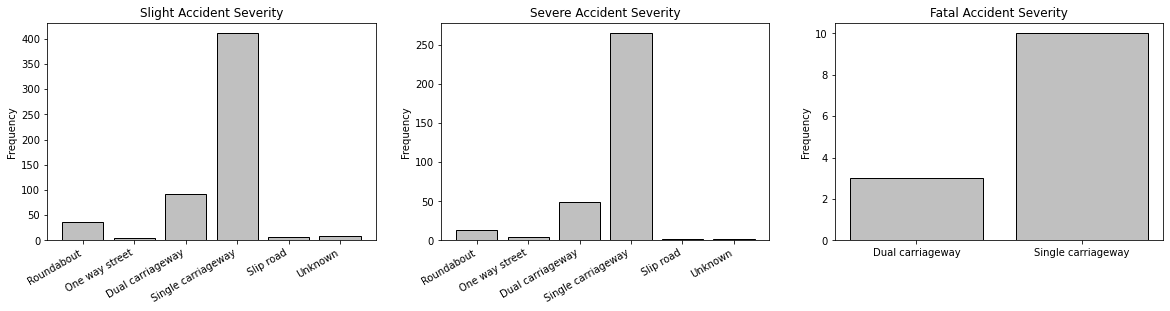

In [67]:
fig, ax = plt.subplots(1,3, figsize=(20, 4))

mask = (sheffield_data["accidents"]["Accident_Severity"] == 3)
ac3_count = sheffield_data["accidents"]["Road_Type"][mask].value_counts()
ac3_unq = sheffield_data["accidents"]["Road_Type"].unique()

ax[0].set_title("Slight Accident Severity")
ax[0].set_ylabel("Frequency")
ax[0].bar(range(0,6), ac3_count.sort_index(),color = 'silver', edgecolor = 'black');
ax[0].set_xticklabels(["", "Roundabout",
                       "One way street", 
                       "Dual carriageway", 
                       "Single carriageway", 
                       "Slip road", 
                       "Unknown"], rotation=30, ha="right")



mask = (sheffield_data["accidents"]["Accident_Severity"] == 2)
ac2_count = sheffield_data["accidents"]["Road_Type"][mask].value_counts()
ac2_unq = sheffield_data["accidents"]["Road_Type"].unique()

ax[1].set_title("Severe Accident Severity")
ax[1].set_ylabel("Frequency")
ax[1].bar(range(0,6), ac2_count.sort_index(),color = 'silver', edgecolor = 'black');
ax[1].set_xticklabels(["", "Roundabout",
                       "One way street", 
                       "Dual carriageway", 
                       "Single carriageway", 
                       "Slip road", 
                       "Unknown"], rotation=30, ha="right")



ac1 = sheffield_data["accidents"][(sheffield_data["accidents"]["Accident_Severity"] == 1)]


mask = (sheffield_data["accidents"]["Accident_Severity"] == 1)
ac1_count = sheffield_data["accidents"]["Road_Type"][mask].value_counts()
ac1_unq = sheffield_data["accidents"]["Road_Type"].unique()



ax[2].set_title("Fatal Accident Severity")
ax[2].set_ylabel("Frequency")
ax[2].bar(range(0,2), ac1_count.sort_index(), tick_label = ["Dual carriageway", "Single carriageway"], color = 'silver', edgecolor = 'black');

Now the fatal accidents on Single carriageway is to be analysed

From the previous map visualization, it shows that none of these fatal accidents occured in the same place. Thus one can conclude that it is the result of one location and there must be a common occurence in these accidents. 

In [68]:
print(ac1["Number_of_Vehicles"].value_counts())

1    9
2    2
3    2
Name: Number_of_Vehicles, dtype: int64


Majority of these accidents occured by only one vehicle being part of the accident ...

In [69]:
print(ac1["Number_of_Casualties"].value_counts())

1    11
2     2
Name: Number_of_Casualties, dtype: int64


... and majority of the accidents involved one casualty

In [70]:
print(ac1["Light_Conditions"].value_counts())

1    8
4    5
Name: Light_Conditions, dtype: int64


8 of the 13 accidents occured in full daylight and the rest occured in Darkness, though the lights were lit. Thus one can conclude that the accidents were not caused by lack of lighting. Though it is unclear whether the lighting is adequate for the road type. This would be tested by travelling to the location of the accident and inspecting the lighting conditions  

In [71]:
print(ac1["Time"].sort_values())

46352    02:30
44676    04:09
45416    07:16
45630    08:08
44799    09:03
46003    09:55
44756    10:37
45924    14:20
45818    14:40
46213    17:41
46450    19:25
45529    22:19
45637    23:44
Name: Time, dtype: object


4 accidents occured in the late evening, night or early morning, the rest of the accidents occured from 07.00 to 19.30. It could be thought that the cause for these four accidents could be the time of the day and that they perhabs had gotten drowsy during the day.

In [72]:
print(ac1["Junction_Detail"].value_counts())

3    8
0    3
6    1
9    1
Name: Junction_Detail, dtype: int64


Majority of these accidents occured in/at a T or staggered junction. Thus this could be the cause of poor speed regulation, bad view of other cars, pedestrians and/or cyclist. 

In [73]:
print(ac1["Junction_Control"].value_counts())

 4    9
-1    3
 2    1
Name: Junction_Control, dtype: int64


Almost all of these accidents occured at a "Give way or uncontrolled" junction control. Which could imply that there could be room for improve on this factor

In [74]:
print(ac1["Weather_Conditions"].value_counts())

1    11
2     2
Name: Weather_Conditions, dtype: int64


11 of the fatal accidents occured in "Fine no high winds" and 2 of the fatal accidents occured in "Raining no high winds"

In [75]:
common = ac1.merge(sheffield_data["casualties"],on=['Accident_Index','Accident_Index'])

In [76]:
common["Casualty_Class"].value_counts()

3    8
1    7
Name: Casualty_Class, dtype: int64

Half of the people that were in the accidents were "pedestrians" where as the other half was "driver or rider" ...

In [77]:
common["Casualty_Severity"].value_counts()

1    14
3     1
Name: Casualty_Severity, dtype: int64

... of which 14 died and one had slight injuries

In [78]:
common["Pedestrian_Location"].value_counts()

0     7
9     5
4     1
5     1
10    1
Name: Pedestrian_Location, dtype: int64

5 subjects were in carriageway and crossing elsewhere.

In [79]:
full = common.merge(sheffield_data["vehicles"],on=['Accident_Index','Accident_Index'])

In [80]:
full["Vehicle_Manoeuvre"].value_counts()

18    11
2      8
7      2
4      1
6      1
9      1
10     1
Name: Vehicle_Manoeuvre, dtype: int64

11 vehicles in the manoeuvre leading up to the accident was "Going ahead other" and 8 vehicles were parked. One can think that the parked vehicles did not play a part in the accidents. Also since there were more cars involved in the accident than casulaties, must one conclude that the vehicles "Going ahead other" drove into the parked cars

In [81]:
full["Junction_Location"].value_counts()

0    13
1     4
2     3
6     2
8     2
5     1
Name: Junction_Location, dtype: int64

Majority of the vehicles in the accidents were "Not at or within 20 metres of junction", majority of the remaining cars where parked

In [82]:
full["Sex_of_Driver"].value_counts()

1    15
3     8
2     2
Name: Sex_of_Driver, dtype: int64

Majority of the sex of the driver was male, in fact 15 of the vehicles that occured in the accident was male. 8 was unknown, which probably was the owners of the parked cars

In [83]:
full["Age_of_Driver"].value_counts()

-1     8
 39    4
 54    2
 34    1
 70    1
 38    1
 49    1
 51    1
 20    1
 21    1
 22    1
 56    1
 25    1
 66    1
Name: Age_of_Driver, dtype: int64

The age range that had the most fatal accidents in Sheffield was the age range from 35 to 60. Which would contradict popular belief that young people are the main cause of trafic accidents.

In [84]:
full["Skidding_and_Overturning"].value_counts()

0    21
1     4
Name: Skidding_and_Overturning, dtype: int64

Four of the vehicles in the accidents skidded, which could imply poor judgement of conditions

In [85]:
ac1["Special_Conditions_at_Site"].value_counts()

0    13
Name: Special_Conditions_at_Site, dtype: int64

### Conclusion

Our suggestion to reduce the frequency of fatal accidents, would be to set up proper/improve signage so that vehicles either can physically not drive faster or perhaps add chicanes. Since majority of the fatal casualties were pedestrians that did not cross at a pedestrian crossing, adding more pedestrian crossing or improving pedestrian conditions could reduce accidents of pedestrians crossing a road not at a pedestrian crossing. Also a Single Carriageway is a road that is not meant for pedestrian crossing.